## *Towards Deep Understanding: An Introductory Tutorial on Causal Inference*

#### [Serbian Machine Learning Workshop](https://workshops.eeml.eu/) part of the [EEML](https://www.eeml.eu/home) Workshop Series 2022

####### **Presenter:** Matej Zečević (feel free to visit: [matej-zecevic.de](https://matej-zecevic.de) for open-access articles on science and culture)

**Abstract:** In this practical session the attendee is going to explore concepts from causality in the formalized notion from Turing award winner Judea Pearl (key reference here is the book "Causality" 2009 Cambridge University Press, but we will also explore notions from subsequent literature as in "Elements of Causal Inference " 2017 from Peters et al. in MIT Press) in a machine learning context. These concepts involve reasoning about causal relations themselves (known as causal discovery) but also reasoning about causal effects (known as causal identification/estimation). To succeed in such an endeavour it takes not only data but also assumptions (or inductive biases) that can alleviate inference to reason about true causal relations exposed by the system under investigation, as famously put by Pearl himself the community must go beyond current machine learning which "amounts to only curve fitting". We will explore examples that make clear why this arguably harsh sentiment towards current practices in deep learning can find justification in formulable notions that make apparent why and how the field might continue to evolve towards the original dream of artificial intelligence. The attendee must not be afraid of exploring this growing field at the intersection of causality and machine learning at new since this practical will allow to follow from the ground-up with simple examples, yet leave room for cutting edge research revolving around modern models such as graph neural networks. The attendee will learn to recognize that deep learning has the potential to evolve towards deep understanding and hopefully this practical will motivate to engage in a community effort towards causal machine learning.

### Table of Content:

* **[1] On Why We Need Causality**
* **[2] Introducing Elements of Causal Reasoning**
    * [2.1] Consequence of Pearl's Causal Hierarchy
    * [2.2] Our Causal Representation of Choice: The Structural Causal Model
* **[3] How do we get the Graph? Onto Causal Discovery!**
* **[B] Bonus: We have the Graph. What do we do with it?**
    * [B.1] Complimenting the $do$-Calculus with Neural Networks
    * [B.2] Bounding Causal Effects from Causal Assumptions

Recommendation for Self-Study:
* etc.

Since this tutorial provides code, we will have to use several libraries to help us compile the content of this tutorial and fix some preliminary setting. Below is the full set of dependencies, each explained via a comment.

In [16]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_palette("cubehelix")
np.random.seed(0)
random.seed(0)

### [1] On Why We Need Causality

On a simple example we will make clear why the Pearlian notion of Causality is crucial for next-generation learning systems, which we require to reason about settings outside their "comfort zone" i.e., outside the available data or in scenarios similar yet distinct of what is known.

The following example is based on Peters et al. 2016.

First, we load our data set which contains 200 samples of activities of two genes $A$ and $B$ recorded alongside a phenotype $P$.

In [17]:
df = pd.read_csv("Dataset-Example-Phenotype-and-Genes.csv")

Let's now visualize the data.

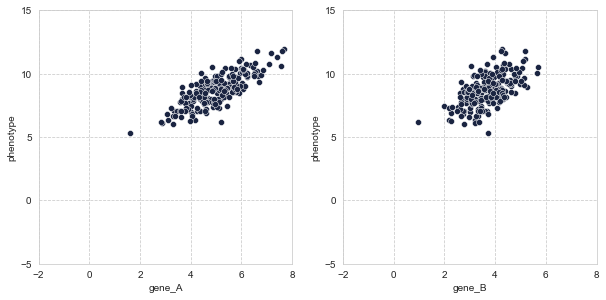

     Unnamed: 0  confounder    gene_A    gene_B  phenotype   distribution
0             0    4.564966  5.028408  3.423724   8.452133  observational
1             1    5.657682  4.601939  4.243262   8.845200  observational
2             2    1.259899  5.211323  0.944925   6.156248  observational
3             3    5.973577  4.797606  4.480183   9.277788  observational
4             4    6.175155  4.378072  4.631367   9.009438  observational
..          ...         ...       ...       ...        ...            ...
195         195    4.357149  6.511865  3.267862   9.779727  observational
196         196    4.413653  5.322205  3.310240   8.632445  observational
197         197    4.553129  3.625206  3.414847   7.040052  observational
198         198    3.981114  5.819953  2.985836   8.805789  observational
199         199    5.697410  6.061435  4.273057  10.334492  observational

[200 rows x 6 columns]


In [18]:
fig, axs = plt.subplots(1,2,figsize=(10,7))

x='gene_A'
y='phenotype'
sns.scatterplot(data=df, x=x, y=y, ax=axs[0])
axs[0].set_yticks(np.arange(0-5, 15+5, 5.0))
axs[0].set_xticks(np.arange(0-2, 8+2, 2.0))
axs[0].set_aspect(1./axs[0].get_data_ratio())

x='gene_B'
y='phenotype'
sns.scatterplot(data=df, x=x, y=y, ax=axs[1])
axs[1].set_yticks(np.arange(0-5, 15+5, 5.0))
axs[1].set_xticks(np.arange(0-2, 8+2, 2.0))
axs[1].set_aspect(1./axs[1].get_data_ratio())

plt.show()
print(df)

We clearly observe a strong correlation between both $(A,P)$ and $(B,P)$.

Let's fit a simple machine learning model (Linear Regression) to our data now such that we can flexibly predict arbitrary inputs. 

Therefore, let's also visualize said model.

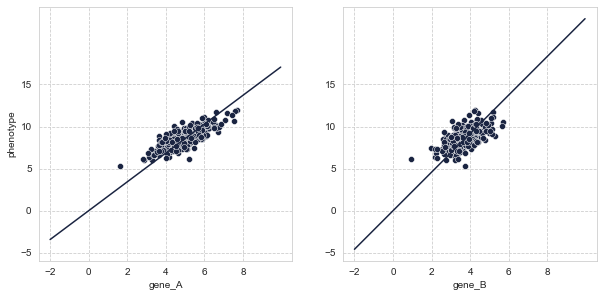

In [19]:
models = [LinearRegression(fit_intercept=False) for i in range(2)]

fig, axs = plt.subplots(1,2,figsize=(10,7), sharex='col', sharey='row')

for ind, x in enumerate(['gene_A', 'gene_B']):
    
    features = df[x][:,np.newaxis]
    targets = df[y]
    models[ind].fit(features, targets)
    prediction_intervall = np.arange(0-2, 8+2, 0.05)[:,np.newaxis]
    predictions = models[ind].predict(prediction_intervall)
    
    sns.scatterplot(data=df, x=x, y=y, ax=axs[ind])
    axs[ind].plot(prediction_intervall, predictions)
    axs[ind].set_yticks(np.arange(0-5, 15+5, 5.0))
    axs[ind].set_xticks(np.arange(0-2, 8+2, 2.0))
    axs[ind].yaxis.set_tick_params(labelbottom=True)
    axs[ind].set_box_aspect(1.)

plt.show()

#### Question Time

We want to find out more about the relation between $A, B$ and $P$. Therefore, we decide to conduct two experiments in the biology lab that initially collected our data, since they have the capabilities to do so. The experiments will set each the activity of a gene to zero (we will denote this with $do(A=0)$ and $do(B=0)$) and record the data, respectively.

**Q: What can we expect from such an experimental setup?**

**A:** Well, we have a trained machine learning model. Why not just ask it what it thinks?

Therefore, in both cases we'd expect the value predicted by our two models when we set our input to 0 i.e., $f(0)$ where $f$ is our learned model --- which in this case evaluates to approx. 0 in both cases.

Our answer, we expect the phenotype to react to our experiments and become 0.

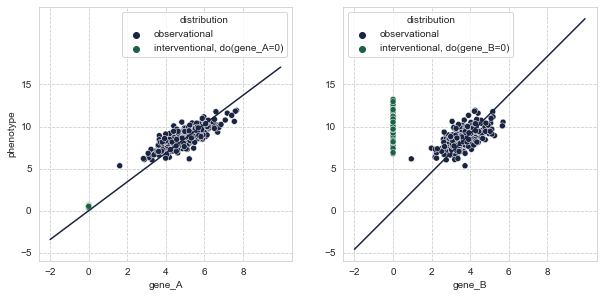

In [20]:
df_pool1 = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Pool-1.csv")
df_pool2 = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Pool-2.csv")

dfs = [df_pool1, df_pool2]

fig, axs = plt.subplots(1,2,figsize=(10,7), sharex='col', sharey='row')
for ind, x in enumerate(['gene_A', 'gene_B']):
    
    features = df[x][:,np.newaxis]
    targets = df[y]
    models[ind].fit(features, targets)
    prediction_intervall = np.arange(0-2, 8+2, 0.05)[:,np.newaxis]
    predictions = models[ind].predict(prediction_intervall)
    
    sns.scatterplot(data=dfs[ind], x=x, y=y, ax=axs[ind], hue='distribution')
    axs[ind].plot(prediction_intervall, predictions)
    axs[ind].set_yticks(np.arange(0-5, 15+5, 5.0))
    axs[ind].set_xticks(np.arange(0-2, 8+2, 2.0))
    axs[ind].yaxis.set_tick_params(labelbottom=True)
    axs[ind].set_box_aspect(1.)

plt.show()

Well, this is unexpected.. (not in the scope of this presentation, but as a genuine result.)

The experimental results provided to us hold accurately in one case but are *completely off in the other*.

The question arises **Why?** (this might also be one of the reasons J. Pearl named his 2018 book "The Book of Why".)


**We conclude that machine learning using *only data* is not sufficient, even in this simple setting - we could not have predicted correctly, the only correct answer was "I don't know". Therefore, we need to go *beyond*!**

### [2] Introducing Elements of Causal Reasoning

One possible explanation for what we just observed in the previous section is that the underlying data generating process (i.e., the physical reality that governs the relation of $A, B$ and $P$) is somehow different between the two pairs $(A,P)$ and $(B,P)$ in that $A$ changes $P$ but $B$ does not change $P$.

Such a notion of *change* is what is being captured by the Pearlian notion of Causality.

I.e., we say $A$ causes $P$ but $B$ does not cause $P$.

Now, you might ask, how did they corrolate ($B$ and $P$) so strongly in the first place?

Well, the simple answer is, that $B$ and $P$ are affected by a common cause, a (hidden) *confounder*.

Graphically, we can depict this intution as
$$
A\rightarrow P
$$
and
$$
B\leftarrow C \rightarrow P
$$
where $C$ is said hidden confounder. (Hidden, because we only now started hypothesizing that it must exist.)

To summarize, we needed to go "outside" our data and model choice to the *assumptions* over what generated our data, to finally come up with a distinction of the previous two settings, which otherwise looked indiscernible.

#### [2.1] Consequence of Pearl's Causal Hierarchy

The experiments that we have conducted are known as *interventions* in causality.

And by observing this interventional data, we were able to conclude the graphs underlying our data.

Let's try to capture this idea from ground-up, with simple toy data that we will generate ourselves.

We will call this "base" data, *observational* data.

Let
$$
A = U_A
$$
and
$$
B = A \wedge U_B
$$
with $\wedge$ being logical and, and $U_A,U_B$ be independent and identically distributed, say, just a random, fair coin flip $\mathcal{B}(0.5)$.

We use $U$ to denote something "**U**nmodelled" (things we forgot, don't know about or simply see as noise).

In [21]:
def toy_data(N):
    """
        N is the number of samples
    """
    U_A = np.random.binomial(1,.5,(N,1))
    U_B = np.random.binomial(1,.5,(N,1))
    A = U_A
    B = np.logical_and(A, U_B)
    return np.hstack((A, B))

Let's simulate our data now by sampling the noise terms and instantiating them.

This gives us our observational distribution.

Var(A)=0.25, Var(B)=0.19,


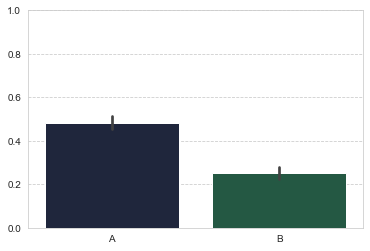

In [22]:
df = pd.DataFrame(toy_data(N=1000), columns=["A","B"])

print(f"Var(A)={np.var(df['A']):.2f}, Var(B)={np.var(df['B']):.2f},")

sns.barplot(data=df)
plt.ylim(0,1)
plt.show()

As expected, $P(A)=0.5$, whereas $P(B)=0.25$ since we can see it as two subsequent fair coin flips.

Now, as before, we would like to do an experiment, an intervention, but this time *we control the data*, so to perform an intervention $do(A=1)$ we simply "hardcode" $A$ to be assigned $1$.

Var(A)=0.00, Var(B)=0.25,


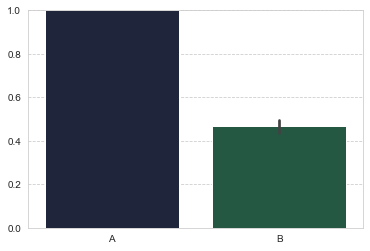

In [23]:
def toy_data_int_A(N):
    """
        N is the number of samples
    """
    U_A = np.random.binomial(1,.5,(N,1))
    U_B = np.random.binomial(1,.5,(N,1))
    A = np.ones((N,1))
    B = np.logical_and(A, U_B)
    return np.hstack((A, B))

df_int_A = pd.DataFrame(toy_data_int_A(N=1000), columns=["A","B"])

print(f"Var(A)={np.var(df_int_A['A']):.2f}, Var(B)={np.var(df_int_A['B']):.2f},")

sns.barplot(data=df_int_A)
plt.ylim(0,1)
plt.show()

As expected, since $A$ changed and $A$ is a cause of $B$ by definition, we see a change in $B$ i.e., $P(B|do(A=1))=0.5$.

Interestingly, this intervention coincides with the *conditional* probability distribution $p(B|A=1)$ which we get by rules of probability theory $p(B|A)=\frac{p(A,B)}{p(A)}$ i.e., we simply look at all $B$'s where $A=1$. (Note, the decimal differences are due to sampling, in the limit of $N\rightarrow \infty$ samples we will have equality.)

In [24]:
print(f'Conditional Probability P(B=1|A=1)={sum(df.iloc[np.where(df["A"]==1)]["B"])/len(df.iloc[np.where(df["A"]==1)]):.2f}')
print(f'Interventional Probability P(B=1|do(A=1))={sum(df_int_A["B"])/len(df_int_A):.2f}')

Conditional Probability P(B=1|A=1)=0.52
Interventional Probability P(B=1|do(A=1))=0.47


Generally, interventions are different from observations and thus conditioning (i.e., the above example was a special case since $A$ is the only cause of $B$) as this simple example where we intervene on $B$ shows.

Var(A)=0.25, Var(B)=0.00,


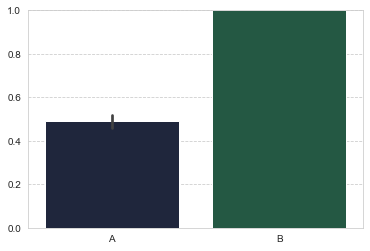

Conditional Probability P(A=1|B=1)=1.00
Interventional Probability P(A=1|do(B=1))=0.49


In [25]:
def toy_data_int_B(N):
    """
        N is the number of samples
    """
    U_A = np.random.binomial(1,.5,(N,1))
    U_B = np.random.binomial(1,.5,(N,1))
    A = U_A
    B = np.ones((N, 1))
    return np.hstack((A, B))

df_int_B = pd.DataFrame(toy_data_int_B(N=1000), columns=["A","B"])

print(f"Var(A)={np.var(df_int_B['A']):.2f}, Var(B)={np.var(df_int_B['B']):.2f},")

sns.barplot(data=df_int_B)
plt.ylim(0,1)
plt.show()

print(f'Conditional Probability P(A=1|B=1)={sum(df.iloc[np.where(df["B"]==1)]["A"])/len(df.iloc[np.where(df["B"]==1)]):.2f}')
print(f'Interventional Probability P(A=1|do(B=1))={sum(df_int_B["A"])/len(df_int_B):.2f}')

As predicted, $P(B|A)\neq P(B|do(A))$ since in the former we observe $B$ (i.e., the noise terms $U_i$ get instantiated and thus fixed) whereas in the latter we actually change the cause of $B$ by deciding that it now corresponds to a constant. The graph changes thus to the disconnected graph
$$
A \not\rightarrow B.
$$

So, knowing $B$ was $1$ implies that $A$ was also $1$ whereas setting $B$ to $1$ renders $B$ independent of $A$.

To summarize, we can ask these questions:

* **Q1 (observational):** What is the probability of $B$ being $1$, formally $P(B=1)$?
* **Q2 (conditional):** I know that $A$ is 1, so how does this change my belief in $B$ being $1$, formally $P(B=1|A=1)$?
* **Q3 (interventional):** We have done an experiment where we set $A$ to 1, what is our belief in $B$ being $1$, formally $P(B=1|do(A=1))$?

As you might have thought of yourself, we can also combine Q2 and Q3 to form a third type of reasoning, that is, we might ask *retrospectively*:

**Q4 (counterfactual)** We have seen both $A,B$ being 0, but if we had changed $B$ to $1$ what are the chances $A$ would have been $1$, formally $P(A=0|do(B=1),A=1,B=0)$?

To give an example for Q4, imagine $A=1$ denoting having a headache and $B=1$ denoting taking an aspirin, then Q4 essentially asks whether we would have cured our headache if we had taken the aspirin since we actually ended up having headache after not taking an aspirin.

#### [2.2] Our Causal Representation of Choice: The Structural Causal Model

In the last section, we took control in our hand and discovered the different notions of reasoning (observational, interventional, counterfactual) from ground-up. Actually, we also used already our representation of choice --- the **Structural Causal Model**, SCM for short.

The description of how $A, B$ are computed are known as structural equations.

More formally, we have an SCM given by
$$
\mathcal{M}=\langle \mathbf{V}, \mathbf{U}, \mathcal{F}, P(\mathbf{U}) \rangle
$$
where $\mathbf{V}$ are our endogenous (observed) variables (e.g. $\mathbf{V}=\{A,B\}$)

where $\mathbf{U}$ are our exogenous (hidden) variables (e.g. $\mathbf{U}=\{U_A,U_B\}$)

where $\mathcal{F}$ are our structural equations (e.g. $\mathcal{F}=\{f_A(U_A)=U_A,f_B(A,U_B)=A+U_B\}$)

and finally where $P(\mathbf{U})$ is a product distribution (our $\mathbf{U}$ are independent).

Again, remember that this is nothing new --- we already discovered it, it just the general formulation!

Also, remember that $\mathcal{M}$ implies a graph structure $G:=G(\mathcal{M})$, which in the cases we consider here, we can simply read off from the structural equations in $\mathcal{F}$.

For example, as before, let $\mathcal{M}=\langle \{A,B\}, \{U_A,U_B\}, \{f_A(U_A)=U_A,f_B(A,U_B)=A+U_B\}, \mathcal{B}(0.5)*\mathcal{B}(0.5) \rangle$ the graph is
$$
A\rightarrow B
$$

**To conclude, the SCM represents our causal system and it is more than just a graph, it is actually a *simulator* that can generate our data and by that implies a graph.**

### [3] How do we get the Graph?

This is the question of concern now. 

We have seen in Section [1] why causality is needed in machine learning by observing a hopeless situation, where regular machine learning fails.

We have seen in Section [2] all key elements of reasoning, and how they connect to what we already know from regular probability theory.

But now that we know what an SCM is, how do we get it, or *how do we even get only the graph?*

In the following, we will use a method from the constraint-based causal discovery literature.

The first ever proven both sound and complete causal discovery algorithm, **Fast Causal Inference**, FCI for short (cite).

The algorithm exploits *conditional independences* found in the data to construct the graph by adhering to what is known as $d$-separation, a graphical criertion which establishes an equivalence to the former by the Markov condition and faithfulness, formally $A \underset{P}{\perp} B | C \iff A \underset{G}{\perp} B | C$ where an independence in $P$ is equivalent to a separation in graph $G$. 

Be assured, we need not go in the details here, but we will simply explore our original biology example using FCI.

In [36]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from linear import notears_linear

def graph_induction(D, method):

    if method == "notears":
        G_pred = notears_linear(D, lambda1 = .1, loss_type = 'l2')
    elif method == "fci":
        G_pred = fci(D, verbose=False)
        G_pred = G_pred[0].graph
    elif method == "pc":
        G_pred = pc(D, verbose=False)
        G_pred = G_pred.G.graph

    return G_pred

Let's load our data again. Note that we are going to only look at our observational data i.e., the data which originally did not help us discern the causal system, since we did not ask for a causal model. That is, we will try to find the true causal graph of $B\leftarrow C\rightarrow P$ just from data points. This time around we will asumme that we observe the confounder $C$ (but we don't know yet whether it is actually a confounder, since of course, we want to know the graph now).

We will consider an alternate version of our data set in which we know the underlying functions to be non-linear, this will render our causal structure *identifiable*.

Also describe NOTEARS.

In [113]:
df = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Nonlinear.csv")

df = pd.DataFrame(np.hstack((confounder, gene_A, gene_B, phenotype)), 
                  columns=['confounder', 'gene_A', 'gene_B', 'phenotype'])
df['distribution'] = ['observational' for _ in range(N)]

df = df.loc[:,["confounder", "gene_B", "phenotype"]]
df

,confounder,gene_B,phenotype
0,-0.537672,-0.155436,-0.536190
1,0.208107,0.009013,0.228719
2,0.979998,0.941186,1.602635
3,2.277776,11.817702,2.287479
4,1.212762,1.783719,3.323583
...,...,...,...
995,-0.991889,-0.975865,-0.597651
996,0.609639,0.226578,0.890405
997,0.201669,0.008202,2.279240
998,-0.676270,-0.309287,-0.595883


In [118]:
D = df.to_numpy()

G_pred_fci = graph_induction(D, method="fci")
G_pred_nt = graph_induction(D, method="notears")

Starting Fast Adjacency Search.



Finishing Fast Adjacency Search.

Not using Matrix Decomposition, directly estimating W.



In [119]:
import utils
from string import ascii_uppercase

<Figure size 432x288 with 0 Axes>

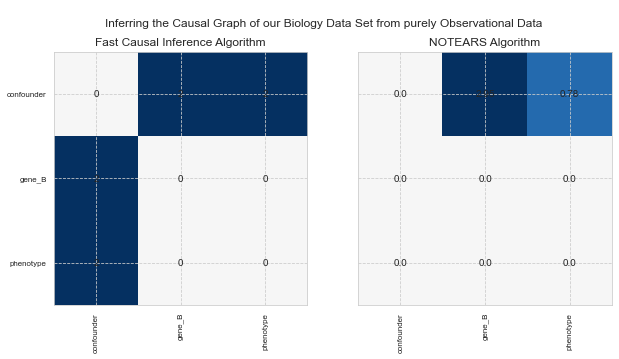

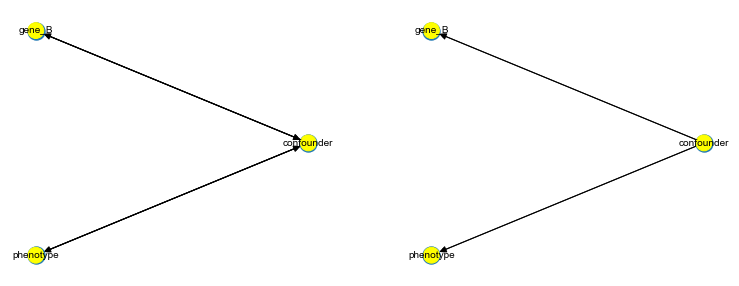

In [130]:
dims = G_pred.shape[0]
dict_visualization = {
    "Fast Causal Inference Algorithm": G_pred_fci,
    "NOTEARS Algorithm": G_pred_nt,
}

sharex = sharey = True
experiment_description = f'''
Inferring the Causal Graph of our Biology Data Set from purely Observational Data
'''
suptitle = f'{experiment_description}'

commonlabel = list(df.columns)
utils.plot_all_individual(list(dict_visualization.values()),
                    list(dict_visualization.keys()),
                    suptitle=suptitle,
                    alt_form=(1,2),
                    alt_size=(10,5),
                    sharex=sharex,
                    sharey=sharey,
                    commonlabel=commonlabel)

dict_cyc_vis = dict_visualization
utils.plot_digraphs_and_cycles(list(dict_cyc_vis.values()), list(dict_cyc_vis.keys()), commonlabel,
                    alt_size=(13,5), arrowsize=14, font_size=10, node_size=250, no_cycles=True)

As expected, both algorithms identify the structure, but FCI only up to Markov Equivalence whereas NOTEARS manages to find the exact causal graph.

**To conclude ...**

### [4] Bonus: We have the Graph. What do we do with it?

Great. We have learned so much already.

We have seen the different phenomena, seen how to formalize it within the SCM, and now even showed how we can get the underlying graph of the SCM --- *without actually performing any interventions ourselves, just from passive data.*

Having the graph, as we know from Section [2] though, is only underlying the SCM.

But what can we do with the graph? We can train a machine learning model to *effectively learn an SCM*.

In the following, we will not actually learn an SCM in the interest of time and space, however, we will assume an SCM given (as before when we actually created one), and will ask the question.

***Once we have the SCM, what can we answer?***

Well, having the SCM means having the capabilities of producing the elements of reasoning from Section [2].

Most often, however, we are interested in a *causal effect* i.e., how does $A$ really *influence* $B$?

Formally, we can capture this with the Average Causal Effect (ACE), in the case of say binary $A,B$ we have

$$
ACE(A,B):= \mathbb{E}[A|do(B=1)]-\mathbb{E}[A|do(B=0)] = P(A=1|do(B=1))-P(A=1|do(B=0)).
$$

As you recognize, whether we have a learned SCM or the actual SCM, the ACE simply defines a difference between two different interventional distributions which we can easily acquire having the former. Done.

#### [B.1] Complimenting the $do$-Calculus with Neural Networks

*But say we did not have the SCM, only the graph. Then we don't know how to get say $P(A|do(B))$?*

The surprising answer: No, we can *identify* $P(A|do(B))$ from purely observational data using our knowledge on the graph.

The previous section covered *structure identification* whereas this is known as *effect identification*.

The celebrated tool for this is Pearl's own $do$-calculus, which is a graphical-algebraic tool proven to be *complete* i.e., any effect tha can be identified will get an answer from $do$-calculus and if it cannot be identified, then $do$-calculus will also let you know.

Let us look at the following example.

The SCM $\mathcal{M}$ is given with the structural equations (with standard normal noise terms)

$$
\begin{align}
A &= f_A(U_A) = U_A \\
B &= f_B(A,U_B) = A^2 + U_B \\
C &= f_R(A,B,U_C) = A^2 + B^3 + U_C
\end{align}
$$

then the implied graph is $A\rightarrow \{B,C\}; B\rightarrow C$ and $do$-calculus will reveal that

$$
p(C|do(B))=\int p(C|A,B)p(A) dA
$$

where the r.h.s. are all observational, probabilistic terms that we can learn from empirical data following $p(A,B,C)$ (!) and we call this r.h.s. the *estimand* (an observational estimand of a causal quantity).

More specifically, we can learn a neural net (or e.g. a sum-product network for tractability and probability guarantees) to estimate the components of the estimand and thus answer our causal query!

Let's define the above SCM and then train a simple neural network.

Var(A)=1.01, Var(B)=3.17, Var(C)=143.39


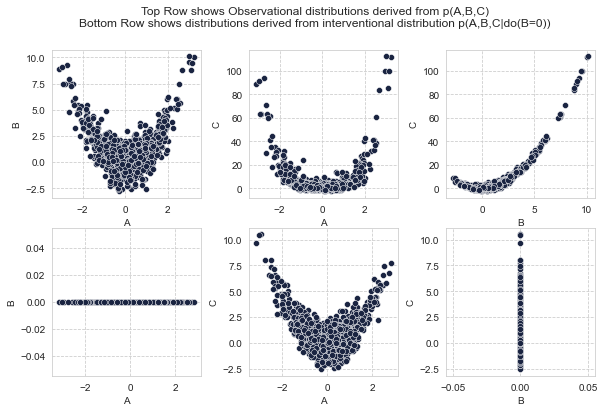

In [290]:
def toy_data(N):
    """
        N is the number of samples
    """
    U_A = np.random.normal(0,1,(N,1))
    U_B = np.random.normal(0,1,(N,1))
    U_C = np.random.normal(0,1,(N,1))
    A = U_A
    B = A**2 + U_B
    C = A**2 + B**2 + U_C
    return np.hstack((A, B, C))
df = pd.DataFrame(toy_data(N=1000), columns=["A","B", "C"])

print(f"Var(A)={np.var(df['A']):.2f}, Var(B)={np.var(df['B']):.2f}, Var(C)={np.var(df['C']):.2f}")

def toy_data_int_B0(N):
    """
        N is the number of samples
    """
    U_A = np.random.normal(0,1,(N,1))
    U_B = np.random.normal(0,1,(N,1))
    U_C = np.random.normal(0,1,(N,1))
    A = U_A
    B = np.zeros((N,1))
    C = A**2 + B**2 + U_C
    return np.hstack((A, B, C))
df_int_B0 = pd.DataFrame(toy_data_int_B0(N=1000), columns=["A","B", "C"])


fig,axs = plt.subplots(2,3,figsize=(10,6))
sns.scatterplot(data=df, x='A', y='B', ax=axs[0,0])
sns.scatterplot(data=df, x='A', y='C', ax=axs[0,1])
sns.scatterplot(data=df, x='B', y='C', ax=axs[0,2])
sns.scatterplot(data=df_int_B0, x='A', y='B', ax=axs[1,0])
sns.scatterplot(data=df_int_B0, x='A', y='C', ax=axs[1,1])
sns.scatterplot(data=df_int_B0, x='B', y='C', ax=axs[1,2])
for a in axs.flatten():
    a.set_box_aspect(1.)
plt.suptitle("Top Row shows Observational distributions derived from p(A,B,C)\nBottom Row shows distributions derived from interventional distribution p(A,B,C|do(B=0))")
plt.show()

We are going to try to compute the interventional distribution $p(C|do(B=0))$ (the lower three plots) using our estimand.

We will fit two separate neural nets, one for $p(C|B,A)$ and one for $p(A)$.

In [291]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

Epoch: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


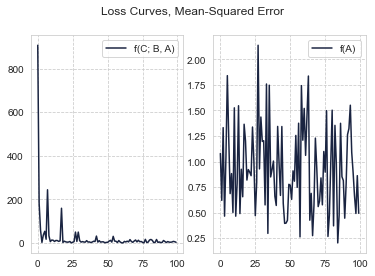

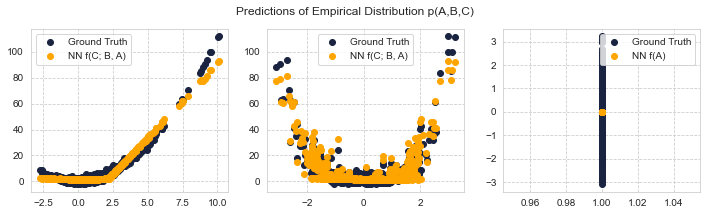

In [292]:
class NeuralNetwork(nn.Module):
    """
        Simple Multi-Layer Perceptron, MLP with one hidden layer
    """

    def __init__(self, len_inputs):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(len_inputs, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_c_given_ba = NeuralNetwork(len_inputs=2)
net_a = NeuralNetwork(len_inputs=1)
neural_nets = [(net_c_given_ba, "f(C; B, A)"), (net_a, "f(A)")]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

dataset_c_given_ba = Dataset(torch.tensor(df[["B", "A"]].values), torch.tensor(df["C"])[:,None])
dataset_a = Dataset(torch.ones_like(torch.tensor(df["A"])[:,None]), torch.tensor(df["A"])[:,None])
    
dl_c_given_ba = torch.utils.data.DataLoader(dataset_c_given_ba, batch_size=10, shuffle=True, num_workers=1)
dl_a = torch.utils.data.DataLoader(dataset_a, batch_size=10, shuffle=True, num_workers=1)
dataloaders = [dl_c_given_ba, dl_a]

criterion = nn.MSELoss()

epochs = 100
results = {}
for ind, (net,desc) in enumerate(neural_nets):
    loss_curve = []
    optimizer = optim.SGD(net.parameters(), lr=0.0001)
    for e in tqdm(range(epochs), desc="Epoch"):
        current_loss = 0.
        for i, data in enumerate(dataloaders[ind]):

            inputs, targets = data
            inputs = inputs[:, None]
            targets = targets[:, None]

            optimizer.zero_grad()
            output = net(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

        loss_curve.append(loss)
    results.update({desc: loss_curve})

fig, axs = plt.subplots(1,2, sharex=True)
axs[0].plot(range(epochs), results["f(C; B, A)"], label="f(C; B, A)")
axs[1].plot(range(epochs), results["f(A)"], label="f(A)")
axs[0].legend()
axs[1].legend()
plt.suptitle("Loss Curves, Mean-Squared Error")
plt.show()

fig, axs = plt.subplots(1,3, figsize=(12,3))
axs[0].scatter(dataset_c_given_ba.X[:,0],dataset_c_given_ba.y,label="Ground Truth")
axs[0].scatter(dataset_c_given_ba.X[:,0],net_c_given_ba(dataset_c_given_ba.X).detach().numpy(),label="NN f(C; B, A)", color="orange")
axs[1].scatter(dataset_c_given_ba.X[:,1],dataset_c_given_ba.y,label="Ground Truth")
axs[1].scatter(dataset_c_given_ba.X[:,1],net_c_given_ba(dataset_c_given_ba.X).detach().numpy(),label="NN f(C; B, A)", color="orange")
axs[2].scatter(dataset_a.X,dataset_a.y,label="Ground Truth")
axs[2].scatter(dataset_a.X,net_a(dataset_a.X).detach().numpy(),label="NN f(A)", color="orange")
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle("Predictions of Empirical Distribution p(A,B,C)")
plt.show()

As we see, our neural net is capable of approximating the content of the desired distribution. However, note that here we just considered a simple, discriminative setting i.e., if we actually want to have the distribution (capable of simulation), then we should deploy our Neural Net(s) within e.g. Normalizing Flows. If we were to use GNNs, then a natural candidate would be VGAE. But this we keep for another tutorial.

#### [B.2] Bounding Causal Effects from Causal Assumptions

In this final (bonus) subsection of this tutorial, we will consider an advanced topic in causal inference, where we are again given only structural knowledge on the graph alongside our data, and we try to *bound* the causal effect.

The following example is based on ZB17.

They have a non-Markovian SCM i.e., $U1$ is parent to $X$ and $Y$

So we have $M$ defined as 

$$
M = \langle \mathbf{U},\mathbf{V},\mathcal{F},P(\mathbf{U}), \rangle
$$

where 

$$\mathbf{U}=\{U_1, U_2\}, \mathbf{V}=\{X, Y\}, \mathcal{F}=\{f_X=U_1, f_Y=X\oplus U_1 \oplus U2\}$$

and $P(\mathbf{U})=P(U_1)*P(U_2)$ with $P(U_1)=P(U_2)\sim B(.9)$.

In [310]:
N = int(1e7) # make sure that N >= K down below
p1 = p2 = 0.9

def SCM(N,p1,p2):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = U1
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D = SCM(N, p1, p2) # this is observational

We have simulated the SCM for $N$ steps/data points and now print the table.

In [312]:
df = pd.DataFrame(D, columns=["X","Y"])
df

,X,Y
0,1,0
1,0,0
2,1,1
3,1,1
4,1,1
...,...,...
9999995,1,1
9999996,1,1
9999997,1,1
9999998,1,1


We compute the actual probabilities $p_{ij}$.

In [313]:
def joint_probs(df, N):

    p00 = len(df[(df.X == 0) & (df.Y == 0)])
    p01 = len(df[(df.X == 0) & (df.Y == 1)])
    p10 = len(df[(df.X == 1) & (df.Y == 0)])
    p11 = len(df[(df.X == 1) & (df.Y == 1)])

    ps = [p00, p01, p10, p11]
    ps = [x/N for x in ps]
    
    return ps

ps = joint_probs(df, N)

assert(np.allclose(sum(ps), 1.))

print(f'p(X=0,Y=0)={ps[0]}\np(X=0,Y=1)={ps[1]}\np(X=1,Y=0)={ps[2]}\np(X=1,Y=1)={ps[3]}\n')

p(X=0,Y=0)=0.0099861
p(X=0,Y=1)=0.0898932
p(X=1,Y=0)=0.0899848
p(X=1,Y=1)=0.8101359



Next we will check their precise numbers regarding causal effect $\mu_x = \mathbb{E}[Y|do(x)]$.
Obviously, for the non-Markovian variant (where $U_1$ is a confounder, but note observed!) the effect is not
identifiable, meaning that we can have another SCM $M'$ which has a different $\mu_x$.

First, we will intervene $M$ to create $M'$.

Second, we simulate $M'$ to get to the probabilities.

In [314]:
def SCM_intervened(N,p1,p2, interv):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = np.repeat(interv, N)
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D_i0 = SCM_intervened(N, p1, p2, interv=0) # this is intervened do(X=0)
D_i1 = SCM_intervened(N, p1, p2, interv=1)

ps_i0 = joint_probs(pd.DataFrame(D_i0, columns=["X","Y"]), N)
ps_i1 = joint_probs(pd.DataFrame(D_i1, columns=["X","Y"]), N)

assert(np.allclose(sum(ps_i0), 1.))
assert(np.allclose(sum(ps_i1), 1.))

print(f'Intervention do(X=0):\n p(X=0,Y=0)={ps_i0[0]}\np(X=0,Y=1)={ps_i0[1]}\np(X=1,Y=0)={ps_i0[2]}\np(X=1,Y=1)={ps_i0[3]}\n')
print(f'Intervention do(X=1):\n p(X=0,Y=0)={ps_i1[0]}\np(X=0,Y=1)={ps_i1[1]}\np(X=1,Y=0)={ps_i1[2]}\np(X=1,Y=1)={ps_i1[3]}\n')


Intervention do(X=0):
 p(X=0,Y=0)=0.8199994
p(X=0,Y=1)=0.1800006
p(X=1,Y=0)=0.0
p(X=1,Y=1)=0.0

Intervention do(X=1):
 p(X=0,Y=0)=0.0
p(X=0,Y=1)=0.0
p(X=1,Y=0)=0.1797751
p(X=1,Y=1)=0.8202249



And indeed our result is correct, if you look at above.

Remember $\mu_x = \mathbb{E}[Y|do(X=x)] = \sum_y y*p(Y|do(X=x))$. Since $y\in\{0,1\}$ we have that $\mu_x = p(Y=1|do(X=x))$

In ZB17 they claim $\mu_0 = 0.18, \mu_1 = 0.82$.


Next, we start looking into the actual interesting stuff namely the bounds. They don't have the intervened SCM $M'$ of course but only $P_M(X,Y)$ (not even the $U$, see Task 1 (4) in ZB17).

Bound is given by $$\mathbb{E}[Y|do(X=0)] \geq l := p_{01}, \quad \mathbb{E}[Y|do(X=1)] \geq l := p_{11}$$ 

and 

$$\mathbb{E}[Y|do(X=0)] \leq h := l + p_{10} + p_{11}, \quad \mathbb{E}[Y|do(X=1)] \leq h := l + p_{00} + p_{01}.$$

In [316]:
def compute_bounds(ps):

    l_0 = ps[1]
    l_1 = ps[3]

    h_0 = l_0 + ps[2] + ps[3]
    h_1 = l_1 + ps[0] + ps[1]
    
    return (l_0, h_0), (l_1, h_1)

(l_0, h_0), (l_1, h_1) = compute_bounds(ps)

print(f'l_0 = {l_0:.4f} <= E[Y|do(X=0)]={ps_i0[1]:.4f} <= h_0 = {h_0:.4f}')
print(f'l_1 = {l_1:.4f} <= E[Y|do(X=1)]={ps_i1[3]:.4f} <= h_1 = {h_1:.4f}')

l_0 = 0.0899 <= E[Y|do(X=0)]=0.1800 <= h_0 = 0.9900
l_1 = 0.8101 <= E[Y|do(X=1)]=0.8202 <= h_1 = 0.9100


Now let's plot the bounds tightness as a function of the number of samples $K$ from $P_M(X,Y)$ we get.

(l_0,h_0)=(0.100,0.900)	 (l_1,h_1)=(0.700,0.900)
(l_0,h_0)=(0.140,0.980)	 (l_1,h_1)=(0.780,0.940)
(l_0,h_0)=(0.140,0.980)	 (l_1,h_1)=(0.740,0.900)
(l_0,h_0)=(0.094,0.994)	 (l_1,h_1)=(0.816,0.916)
(l_0,h_0)=(0.092,0.994)	 (l_1,h_1)=(0.813,0.911)
(l_0,h_0)=(0.089,0.991)	 (l_1,h_1)=(0.820,0.917)
(l_0,h_0)=(0.092,0.990)	 (l_1,h_1)=(0.812,0.914)
(l_0,h_0)=(0.092,0.990)	 (l_1,h_1)=(0.808,0.910)
(l_0,h_0)=(0.091,0.990)	 (l_1,h_1)=(0.808,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)


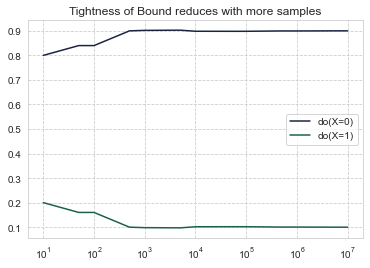

In [318]:
ts_0 = []
ts_1 = []
Ks = [10, 50, 100, 500, 1000, 5000, 10000, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
for K in Ks:
    assert(N >= K)
    ps = joint_probs(df[:int(K)], K)
    assert(np.allclose(sum(ps), 1.))
    (l_0, h_0), (l_1, h_1) = compute_bounds(ps)
    t_0 = h_0-l_0 # "tightness of bound"
    t_1 = h_1-l_1
    ts_0.append(t_0)
    ts_1.append(t_1)
    print(f'(l_0,h_0)=({l_0:.3f},{h_0:.3f})\t (l_1,h_1)=({l_1:.3f},{h_1:.3f})')

plt.plot(Ks, ts_0, label="do(X=0)")
plt.plot(Ks, ts_1, label="do(X=1)")
plt.legend()
plt.title("Tightness of Bound reduces with more samples")
plt.gca().set_xscale('log')
plt.show()

We can see, the bound unfortunately does not improve much and it is only tight-ish on $do(X=1)$ for this specific SCM.

Also, we note that the Theorem 1 from ZB17 only gives guarantees for the actual *exact* probabilities, and here we have only estimates of those and of course with a few samples only these will be wrong.

Yet again, we don't know anything about the structural equations $\mathcal{F}$ in this bound just the base graph essentially, and for that it is actually quite surprising already!

In [303]:
import normflow as nf

device = torch.device('cpu')

n_flows = 3
n_bottleneck = 3
num_samples = 10

hidden_units_encoder = np.array([5, 5, n_bottleneck * 2])
hidden_units_decoder = np.array([n_bottleneck, 5, 5])
prior = torch.distributions.MultivariateNormal(torch.zeros(n_bottleneck, device=device),
                                               torch.eye(n_bottleneck, device=device))
encoder_nn = nf.nets.MLP(hidden_units_encoder)
encoder = nf.distributions.NNDiagGaussian(encoder_nn)
decoder_nn = nf.nets.MLP(hidden_units_decoder)
decoder = nf.distributions.NNBernoulliDecoder(decoder_nn)

flows = [nf.flows.Planar((n_bottleneck,)) for k in range(n_flows)]

nfm = nf.NormalizingFlowVAE(prior, encoder, flows, decoder)
nfm.to(device)

dataset_abc = Dataset(torch.tensor(df[["A", "B", "C"]].values), torch.tensor(df["C"])[:,None])
    
train_loader = torch.utils.data.DataLoader(dataset_abc, batch_size=10, shuffle=True, num_workers=1)

# Train model
log_intv = 100
optimizer = optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-4)
for epoch in range(epochs):
    progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        optimizer.zero_grad()
        z, log_q, log_p = nfm(x.view(x.size(0) * x.size(1), 2*2), num_samples)
        mean_log_q = torch.mean(log_q)
        mean_log_p = torch.mean(log_p)
        loss = mean_log_q - mean_log_p
        loss.backward()
        optimizer.step()
        progressbar.update()
    progressbar.close()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_n * len(x), len(train_loader.dataset),
                       100. * batch_n / len(train_loader),
                       loss.item()))


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: shape '[20, 4]' is invalid for input of size 20

Epoch: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


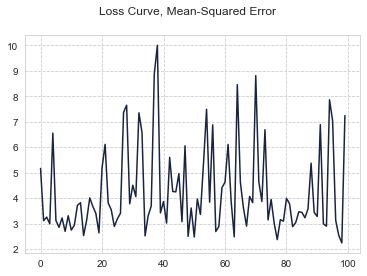

In [309]:

# Define 2D base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 3
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 5, 5, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# If the target density is not given
model = nf.NormalizingFlow(base, flows)

dataset_abc = Dataset(torch.tensor(df[["A", "B", "C"]].values), torch.tensor(df["C"])[:,None])
    
train_loader = torch.utils.data.DataLoader(dataset_abc, batch_size=10, shuffle=True, num_workers=1)
    
epochs = 100
loss_curve = []
optimizer = optim.SGD(net.parameters(), lr=0.0001)
for e in tqdm(range(epochs), desc="Epoch"):
    current_loss = 0.
    for i, (data,_) in enumerate(dataloaders[ind]):
        data = data.to(device)
        optimizer.zero_grad()
        loss = model.forward_kld(data)
        loss.backward()
        optimizer.step()

    loss_curve.append(loss)

plt.plot(range(epochs), loss_curve)
plt.suptitle("Loss Curve, Mean-Squared Error")
plt.show()

# fig, axs = plt.subplots(1,3, figsize=(12,3))
# axs[0].scatter(dataset_c_given_ba.X[:,0],dataset_c_given_ba.y,label="Ground Truth")
# axs[0].scatter(dataset_c_given_ba.X[:,0],net_c_given_ba(dataset_c_given_ba.X).detach().numpy(),label="NN f(C; B, A)", color="orange")
# axs[1].scatter(dataset_c_given_ba.X[:,1],dataset_c_given_ba.y,label="Ground Truth")
# axs[1].scatter(dataset_c_given_ba.X[:,1],net_c_given_ba(dataset_c_given_ba.X).detach().numpy(),label="NN f(C; B, A)", color="orange")
# axs[2].scatter(dataset_a.X,dataset_a.y,label="Ground Truth")
# axs[2].scatter(dataset_a.X,net_a(dataset_a.X).detach().numpy(),label="NN f(A)", color="orange")
# axs[0].legend()
# axs[1].legend()
# axs[2].legend()
# plt.suptitle("Predictions of Empirical Distribution p(A,B,C)")
# plt.show()


Epoch: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


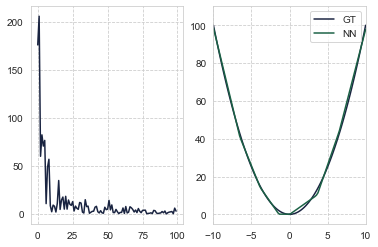

In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    """
        Simple Multi-Layer Perceptron, MLP with one hidden layer
    """

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = NeuralNetwork()

class Dataset(torch.utils.data.Dataset):
    '''
    Quadratic curve dataset
    '''

    def __init__(self, N):
        self.X = torch.linspace(-10,10,N)
        f = lambda x: x**2
        self.y = f(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# x = torch.linspace(-10,10)
# f = lambda x: x**2
# D = torch.stack((x, f(x))).T
dataset = Dataset(N=1000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=1)

import torch.optim as optim
from tqdm import tqdm
criterion = nn.MSELoss()

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.0001)

epochs = 100
loss_curve = []
for e in tqdm(range(epochs), desc="Epoch"):
    
    for data in dataloader:
        
        inputs, targets = data
        inputs = inputs[:, None]
        targets = targets[:, None]
    
        # in your training loop:
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    
    loss_curve.append(loss)

fig, axs = plt.subplots(1,2)
axs[0].plot(range(epochs), loss_curve, label="Loss Curve")
axs[1].plot(D[:,0],D[:,1],label="GT")
axs[1].plot(D[:,0],net(D[:,:1]).detach().numpy(),label="NN")
axs[1].legend()
axs[1].set_ylim(-5,110)
axs[1].set_xlim(-10,10)
plt.show()

#### [B.2] Bounding Causal Effects from Causal Assumptions

In [ ]:
N = 1000
gene_A = np.random.normal(0,1,(N,1))
confounder = np.random.normal(0,1,(N,1))
gene_B = confounder**3
phenotype = confounder + gene_A**2

In [59]:
N = 200
gene_A = np.random.normal(5,1,(N,1))
confounder = np.random.normal(5,1,(N,1))
gene_B = 0.75*confounder
phenotype = 0.75*confounder + gene_A

df = pd.DataFrame(np.hstack((confounder, gene_A, gene_B, phenotype)), 
                  columns=['confounder', 'gene_A', 'gene_B', 'phenotype'])
df['distribution'] = ['observational' for _ in range(N)]

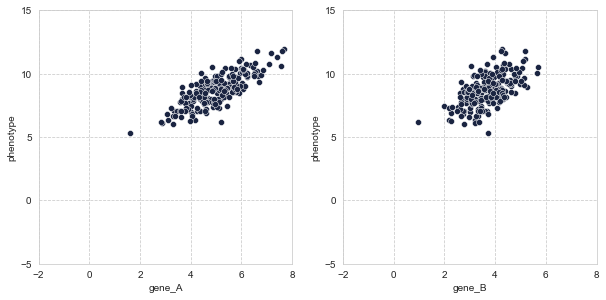

     confounder    gene_A    gene_B  phenotype   distribution
0      4.564966  5.028408  3.423724   8.452133  observational
1      5.657682  4.601939  4.243262   8.845200  observational
2      1.259899  5.211323  0.944925   6.156248  observational
3      5.973577  4.797606  4.480183   9.277788  observational
4      6.175155  4.378072  4.631367   9.009438  observational
..          ...       ...       ...        ...            ...
195    4.357149  6.511865  3.267862   9.779727  observational
196    4.413653  5.322205  3.310240   8.632445  observational
197    4.553129  3.625206  3.414847   7.040052  observational
198    3.981114  5.819953  2.985836   8.805789  observational
199    5.697410  6.061435  4.273057  10.334492  observational

[200 rows x 5 columns]


In [60]:
fig, axs = plt.subplots(1,2,figsize=(10,7))

x='gene_A'
y='phenotype'
sns.scatterplot(data=df, x=x, y=y, ax=axs[0])
axs[0].set_yticks(np.arange(0-5, 15+5, 5.0))
axs[0].set_xticks(np.arange(0-2, 8+2, 2.0))
axs[0].set_aspect(1./axs[0].get_data_ratio())

x='gene_B'
y='phenotype'
sns.scatterplot(data=df, x=x, y=y, ax=axs[1])
axs[1].set_yticks(np.arange(0-5, 15+5, 5.0))
axs[1].set_xticks(np.arange(0-2, 8+2, 2.0))
axs[1].set_aspect(1./axs[1].get_data_ratio())

plt.show()
print(df)

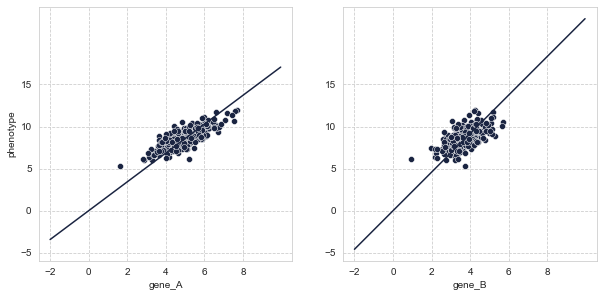

In [68]:
models = [LinearRegression(fit_intercept=False) for i in range(2)]

fig, axs = plt.subplots(1,2,figsize=(10,7), sharex='col', sharey='row')

for ind, x in enumerate(['gene_A', 'gene_B']):
    
    features = df[x][:,np.newaxis]
    targets = df[y]
    models[ind].fit(features, targets)
    prediction_intervall = np.arange(0-2, 8+2, 0.05)[:,np.newaxis]
    predictions = models[ind].predict(prediction_intervall)
    
    sns.scatterplot(data=df, x=x, y=y, ax=axs[ind])
    axs[ind].plot(prediction_intervall, predictions)
    axs[ind].set_yticks(np.arange(0-5, 15+5, 5.0))
    axs[ind].set_xticks(np.arange(0-2, 8+2, 2.0))
    axs[ind].yaxis.set_tick_params(labelbottom=True)
    axs[ind].set_box_aspect(1.)

plt.show()

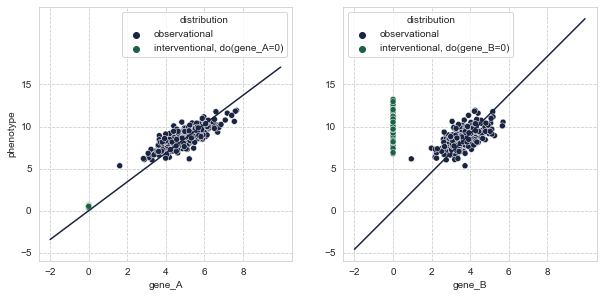

In [69]:
M = 50

gene_A = np.zeros((M,1))
confounder = np.random.normal(5,1,(M,1))
gene_B = confounder
phenotype = 0.1*confounder + gene_A

df_int1 = pd.DataFrame(np.hstack((confounder, gene_A, gene_B, phenotype)), 
                  columns=['confounder', 'gene_A', 'gene_B', 'phenotype'])
df_int1['distribution'] = ['interventional, do(gene_A=0)' for _ in range(M)]
df_pooled_int1 = df.append(df_int1)

gene_A = np.random.normal(5,1,(M,1))
confounder = np.random.normal(5,1,(M,1))
gene_B = np.zeros((M,1))
phenotype = confounder + gene_A

df_int2 = pd.DataFrame(np.hstack((confounder, gene_A, gene_B, phenotype)), 
                  columns=['confounder', 'gene_A', 'gene_B', 'phenotype'])
df_int2['distribution'] = ['interventional, do(gene_B=0)' for _ in range(M)]
df_pooled_int2 = df.append(df_int2)

fig, axs = plt.subplots(1,2,figsize=(10,7), sharex='col', sharey='row')

dfs = [df_pooled_int1, df_pooled_int2]

for ind, x in enumerate(['gene_A', 'gene_B']):
    
    features = df[x][:,np.newaxis]
    targets = df[y]
    models[ind].fit(features, targets)
    prediction_intervall = np.arange(0-2, 8+2, 0.05)[:,np.newaxis]
    predictions = models[ind].predict(prediction_intervall)
    
    sns.scatterplot(data=dfs[ind], x=x, y=y, ax=axs[ind], hue='distribution')
    axs[ind].plot(prediction_intervall, predictions)
    axs[ind].set_yticks(np.arange(0-5, 15+5, 5.0))
    axs[ind].set_xticks(np.arange(0-2, 8+2, 2.0))
    axs[ind].yaxis.set_tick_params(labelbottom=True)
    axs[ind].set_box_aspect(1.)

plt.show()

#### We first define an SCM as in ZB17 (see Proof of Prop 3)
They have a non-Markovian SCM i.e., $U1$ is parent to $X$ and $Y$

So we have $M$ defined as 
$$
M = \langle \mathbf{U},\mathbf{V},\mathcal{F},P(\mathbf{U}), \rangle
$$
where $\mathbf{U}=\{U_1, U_2\}, \mathbf{V}=\{X, Y\}, \mathcal{F}=\{f_X=U_1, f_Y=X\oplus U_1 \oplus U2\}$ and $P(\mathbf{U})=P(U_1)*P(U_2)$ with $P(U_1)=P(U_2)\sim B(.9)$.

In [131]:
N = int(1e7) # make sure that N >= K down below
p1 = p2 = 0.9

def SCM(N,p1,p2):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = U1
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D = SCM(N, p1, p2) # this is observational

We have simulated the SCM for $N$ steps/data points and now print the table.

In [132]:
df = pd.DataFrame(D, columns=["X","Y"])
print(df)

         X  Y
0        1  1
1        1  1
2        1  1
3        0  1
4        1  1
...     .. ..
9999995  1  1
9999996  1  1
9999997  1  1
9999998  1  1
9999999  1  1

[10000000 rows x 2 columns]


We compute the actual probabilities $p_{ij}$.

In [133]:
def joint_probs(df, N):

    p00 = len(df[(df.X == 0) & (df.Y == 0)])
    p01 = len(df[(df.X == 0) & (df.Y == 1)])
    p10 = len(df[(df.X == 1) & (df.Y == 0)])
    p11 = len(df[(df.X == 1) & (df.Y == 1)])

    ps = [p00, p01, p10, p11]
    ps = [x/N for x in ps]
    
    return ps

ps = joint_probs(df, N)

assert(np.allclose(sum(ps), 1.))

print(f'p(X=0,Y=0)={ps[0]}\np(X=0,Y=1)={ps[1]}\np(X=1,Y=0)={ps[2]}\np(X=1,Y=1)={ps[3]}\n')

p(X=0,Y=0)=0.0099407
p(X=0,Y=1)=0.089994
p(X=1,Y=0)=0.0900339
p(X=1,Y=1)=0.8100314



Next we will check whether the $q_{ij}$ decompositions proposed do indeed work.

In [134]:
# actually, don't know how to transform P(U) into P(R_x, R_y)

Next we will check their precise numbers regarding causal effect $\mu_x = \mathbb{E}[Y|do(x)]$.
Obviously, for the non-Markovian variant (where $U_1$ is a confounder, but note observed!) the effect is not
identifiable, meaning that we can have another SCM $M'$ which has a different $\mu_x$.

First, we will intervene $M$ to create $M'$.

Second, we simulate $M'$ to get to the probabilities.

In [135]:
def SCM_intervened(N,p1,p2, interv):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = np.repeat(interv, N)
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D_i0 = SCM_intervened(N, p1, p2, interv=0) # this is intervened do(X=0)
D_i1 = SCM_intervened(N, p1, p2, interv=1)

ps_i0 = joint_probs(pd.DataFrame(D_i0, columns=["X","Y"]), N)
ps_i1 = joint_probs(pd.DataFrame(D_i1, columns=["X","Y"]), N)

assert(np.allclose(sum(ps_i0), 1.))
assert(np.allclose(sum(ps_i1), 1.))

print(f'Intervention do(X=0):\n p(X=0,Y=0)={ps_i0[0]}\np(X=0,Y=1)={ps_i0[1]}\np(X=1,Y=0)={ps_i0[2]}\np(X=1,Y=1)={ps_i0[3]}\n')
print(f'Intervention do(X=1):\n p(X=0,Y=0)={ps_i1[0]}\np(X=0,Y=1)={ps_i1[1]}\np(X=1,Y=0)={ps_i1[2]}\np(X=1,Y=1)={ps_i1[3]}\n')


Intervention do(X=0):
 p(X=0,Y=0)=0.8199084
p(X=0,Y=1)=0.1800916
p(X=1,Y=0)=0.0
p(X=1,Y=1)=0.0

Intervention do(X=1):
 p(X=0,Y=0)=0.0
p(X=0,Y=1)=0.0
p(X=1,Y=0)=0.1798619
p(X=1,Y=1)=0.8201381



And indeed our result is correct, if you look at above.

Remember $\mu_x = \mathbb{E}[Y|do(X=x)] = \sum_y y*p(Y|do(X=x))$. Since $y\in\{0,1\}$ we have that $\mu_x = p(Y=1|do(X=x))$

In ZB17 they claim $\mu_0 = 0.18, \mu_1 = 0.82$.


Next, we start looking into the actual interesting stuff namely the bounds. They don't have the intervened SCM $M'$ of course but only $P_M(X,Y)$ (not even the $U$, see Task 1 (4) in ZB17).

Bound is given by $$\mathbb{E}[Y|do(X=0)] \geq l := p_{01}, \quad \mathbb{E}[Y|do(X=1)] \geq l := p_{11}$$ 

and 

$$\mathbb{E}[Y|do(X=0)] \leq h := l + p_{10} + p_{11}, \quad \mathbb{E}[Y|do(X=1)] \leq h := l + p_{00} + p_{01}.$$

In [136]:
def compute_bounds(ps):

    l_0 = ps[1]
    l_1 = ps[3]

    h_0 = l_0 + ps[2] + ps[3]
    h_1 = l_1 + ps[0] + ps[1]
    
    return (l_0, h_0), (l_1, h_1)

(l_0, h_0), (l_1, h_1) = compute_bounds(ps)

print(f'l_0 = {l_0:.4f} <= E[Y|do(X=0)]={ps_i0[1]:.4f} <= h_0 = {h_0:.4f}')
print(f'l_1 = {l_1:.4f} <= E[Y|do(X=1)]={ps_i1[3]:.4f} <= h_1 = {h_1:.4f}')

l_0 = 0.0900 <= E[Y|do(X=0)]=0.1801 <= h_0 = 0.9901
l_1 = 0.8100 <= E[Y|do(X=1)]=0.8201 <= h_1 = 0.9100


Now let's plot the bounds tightness as a function of the number of samples $K$ from $P_M(X,Y)$ we get.

(l_0,h_0)=(0.300,1.000)	 (l_1,h_1)=(0.700,1.000)
(l_0,h_0)=(0.080,0.980)	 (l_1,h_1)=(0.900,1.000)
(l_0,h_0)=(0.080,0.990)	 (l_1,h_1)=(0.850,0.940)
(l_0,h_0)=(0.084,0.986)	 (l_1,h_1)=(0.840,0.938)
(l_0,h_0)=(0.079,0.988)	 (l_1,h_1)=(0.830,0.921)
(l_0,h_0)=(0.095,0.989)	 (l_1,h_1)=(0.810,0.915)
(l_0,h_0)=(0.094,0.990)	 (l_1,h_1)=(0.810,0.915)
(l_0,h_0)=(0.089,0.990)	 (l_1,h_1)=(0.810,0.909)
(l_0,h_0)=(0.091,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)


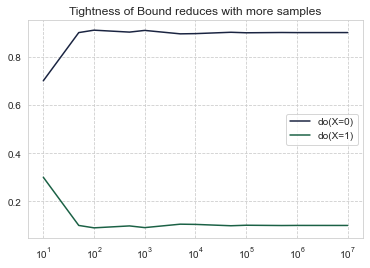

In [137]:
ts_0 = []
ts_1 = []
Ks = [10, 50, 100, 500, 1000, 5000, 10000, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
for K in Ks:
    assert(N >= K)
    ps = joint_probs(df[:int(K)], K)
    assert(np.allclose(sum(ps), 1.))
    (l_0, h_0), (l_1, h_1) = compute_bounds(ps)
    t_0 = h_0-l_0 # "tightness of bound"
    t_1 = h_1-l_1
    ts_0.append(t_0)
    ts_1.append(t_1)
    print(f'(l_0,h_0)=({l_0:.3f},{h_0:.3f})\t (l_1,h_1)=({l_1:.3f},{h_1:.3f})')

plt.plot(Ks, ts_0, label="do(X=0)")
plt.plot(Ks, ts_1, label="do(X=1)")
plt.legend()
plt.title("Tightness of Bound reduces with more samples")
plt.gca().set_xscale('log')
plt.show()

We can see, the bound unfortunately does not improve much and it is only tight-ish on $do(X=1)$ for this specific SCM.

Also, we note that the Theorem 1 from ZB17 only gives guarantees for the actual *exact* probabilities, and here we have only estimates of those and of course with a few samples only these will be wrong.

Yet again, we don't know anything about the structural equations $\mathcal{F}$ in this bound just the base graph essentially, and for that it is actually quite surprising already!

Now, we might as well check for the family of SCMs that share the structure and equations with $M$.

That is, all the different parameterizations $P(\mathbf{U})$ and also across multiple random seeds.

In [ ]:
#%debug
from tqdm.notebook import tqdm

from collections import defaultdict
def recursively_default_dict():
    return defaultdict(recursively_default_dict)
d = recursively_default_dict()

N = int(1e5)
seeds = [230, 12, 4959, 77, 988]
p_vals = [.1, .25, .5, .75, .9]
for seed in tqdm(seeds, desc="Run "):
    for u1 in p_vals:
        for u2 in p_vals:

            D = SCM(N, u1, u2) # this is observational
            D_i0 = SCM_intervened(N, u1, u2, interv=0) # this is intervened do(X=0)
            D_i1 = SCM_intervened(N, u1, u2, interv=1)

            ps = joint_probs(pd.DataFrame(D, columns=["X","Y"]), N)
            ps_i0 = joint_probs(pd.DataFrame(D_i0, columns=["X","Y"]), N)
            ps_i1 = joint_probs(pd.DataFrame(D_i1, columns=["X","Y"]), N)

            ts_0 = []
            ts_1 = []
            Ks = [10, 50, 100, 500, 1000, 5000, 10000, 5e4, 1e5]
            for K in Ks:
                assert(N >= K)
                ps = joint_probs(df[:int(K)], K)
                assert(np.allclose(sum(ps), 1.))
                (l_0, h_0), (l_1, h_1) = compute_bounds(ps)
                t_0 = h_0-l_0 # "tightness of bound"
                t_1 = h_1-l_1
                ts_0.append(t_0)
                ts_1.append(t_1)
                d[str(seed)][str(u1)][str(u2)][str(K)] = (t_0, t_1)

In [ ]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15,15))

for a, u1 in enumerate(p_vals):
    for b, u2 in enumerate(p_vals):
        
        base = [d[seed][str(u1)][str(u2)] for seed in d.keys()]
        base_t_0 = [[t[str(K)][0] for t in base] for K in Ks]
        base_t_1 = [[t[str(K)][1] for t in base] for K in Ks]
        
        mean_ts_0 = np.array([np.mean(base_t_0) for K in Ks])
        std_ts_0 = np.array([np.std(base_t_0) for K in Ks])
        mean_ts_1 = np.array([np.mean(base_t_1) for K in Ks])
        std_ts_1 = np.array([np.std(base_t_1) for K in Ks])
        
        axs[a,b].plot(Ks, ts_0, label="do(X=0)", color='blue')
        axs[a,b].fill_between(Ks, mean_ts_0 - std_ts_0, ts_0 + std_ts_0,
                 color='blue', alpha=0.2)
        
        axs[a,b].plot(Ks, ts_1, label="do(X=1)", color='orange')
        axs[a,b].fill_between(Ks, mean_ts_1 - std_ts_1, ts_1 + std_ts_1,
                 color='orange', alpha=0.2)
        
        axs[a,b].set_title(f"p_1 = {u1}, p_2 = {u2}")
        plt.gca().set_xscale('log')
        
plt.legend()
plt.suptitle(f"Averages over {len(seeds)} random seeds for {len(p_vals)**2} different parameterizations of P(U)")
plt.show()

As we observe, it is consistent across random seeds and furthermore it is consistent across different parameterizations of $P(\mathbf{U})$ suggesting that the structure is the key part in this bound.